In [13]:
import numpy as np
from skimage.color import rgb2gray
import cv2

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

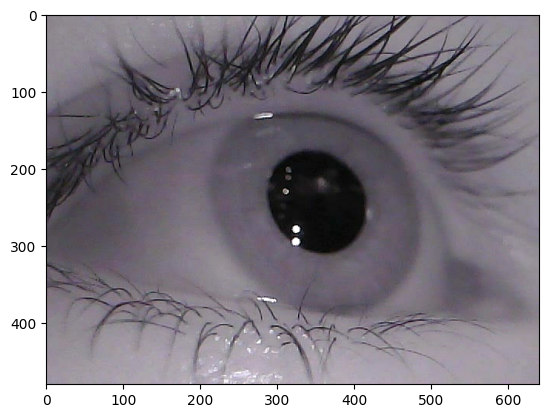

(480, 640, 3)
(480, 640)


In [3]:
image = imread('eye.png')
plt.imshow(image)
plt.show()
print(image.shape)
print(image[:,:,2].shape)

In [52]:
image = rgb2gray(image)
print(image.shape)

(480, 640)


In [53]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize

# Functions from the assignment 1

def gaussian_smoothing(img):
    smoothed_img = gaussian_filter(img, sigma=5)
    return smoothed_img

def gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -1, -2]])
    sobel_x_img = convolve(img, sobel_x, mode='constant')
    sobel_y_img = convolve(img, sobel_y, mode='constant')
    g_magnitude = np.sqrt(sobel_x_img ** 2 + sobel_y_img ** 2)
    g_dir = np.arctan2(sobel_x_img, sobel_y_img)
    return g_magnitude, g_dir

def non_maximum_suppression(g_magnitude, g_dir):
    g_dir[g_dir < 0] += np.pi
    g_dir_hat = np.floor_divide(g_dir, np.pi / 4)
    g_max = np.zeros_like(g_magnitude)
    for x in range(1, g_magnitude.shape[0] - 1):
        for y in range(1, g_magnitude.shape[1] - 1):
            magnitude = g_magnitude[x, y]
            dir_hat = g_dir_hat[x, y]
            if dir_hat == 0:  # east/west
                if np.greater_equal(magnitude, g_magnitude[x, y-1]) and np.greater_equal(magnitude, g_magnitude[x, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 1: #northeast/southwest
                if np.greater_equal(magnitude, g_magnitude[x+1, y-1]) and np.greater_equal(magnitude, g_magnitude[x-1, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 2: #nort/south
                if np.greater_equal(magnitude, g_magnitude[x+1, y]) and np.greater_equal(magnitude, g_magnitude[x-1, y]):
                    g_max[x, y] = magnitude
            elif dir_hat == 3: #nortwest/southeast
                if np.greater_equal(magnitude, g_magnitude[x+1, y+1]) and np.greater_equal(magnitude, g_magnitude[x-1, y-1]):
                    g_max[x, y] = magnitude
    return g_max

def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.zeros_like(g_max)
    for x in range(g_max.shape[0]):
      for y in range(g_max.shape[1]):
          mag = g_max[x, y]   
          if mag > thresh_hi:
              thresh_img[x, y] = 255 #strong
          elif mag > thresh_lo:
              thresh_img[x, y] = 128 #weak
    return thresh_img

def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    for x in range(thresh_img.shape[0]):
      for y in range(thresh_img.shape[1]):
        edge = thresh_img[x,y]
        if edge == 255:
          edge_img[x,y] = edge
        if edge == 128:
          if thresh_img[x-1,y-1]==255 or thresh_img[x-1,y]==255 or thresh_img[x,y-1]==255 or thresh_img[x+1,y]==255 or thresh_img[x+1,y+1]==255:
            edge_img[x,y] = edge
    return edge_img

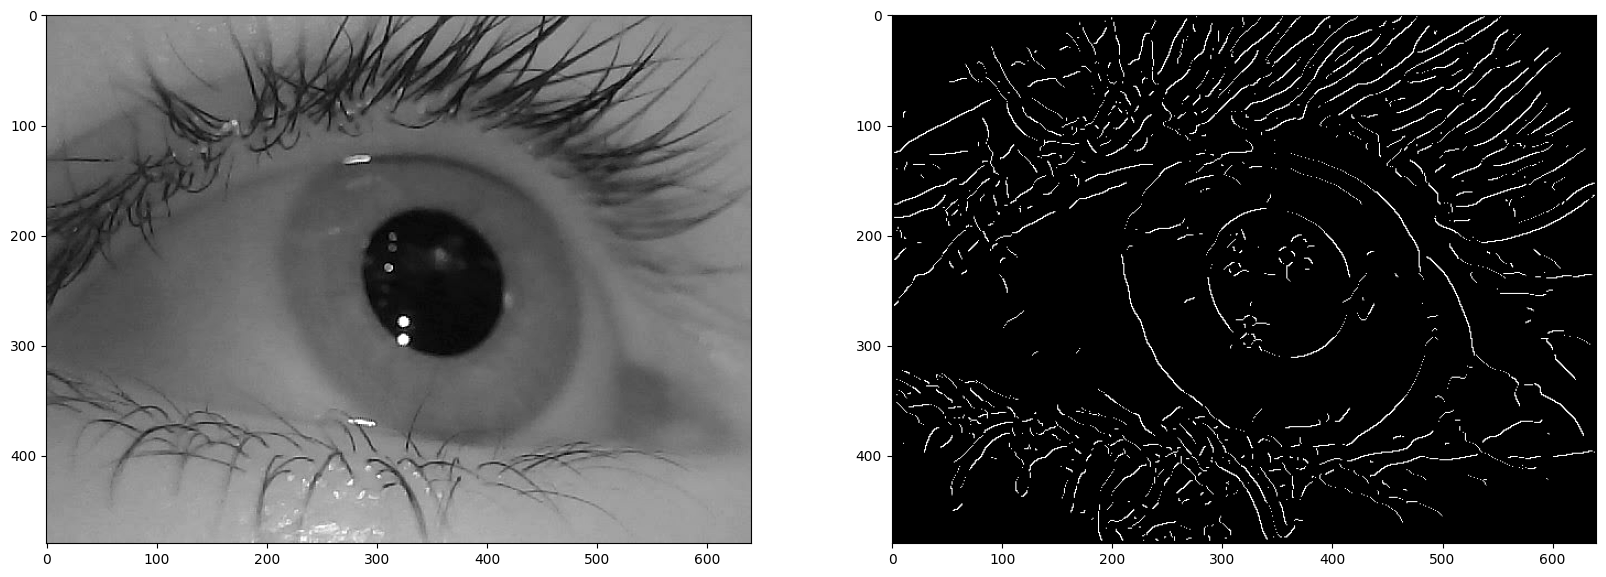

In [54]:
def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.02):
    """
    The Canny edge detector.

    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will
                         be considered the lo threshold.
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x
                         thresh_lo.

    Outputs:
        edge_img         A binary image, with pixels lying on edges marked with a 1,
                         and others with a 0.
    """

    # Smooth the image first.
    smoothed             = gaussian_smoothing(img)

    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)

    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)

    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)

    # Final edge connectivity
    edge_img             = connectivity(thresh_img)

    # Return the result
    return edge_img


edges = canny_edge_detector(image)

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(image, cmap='gray')
axes[1].imshow(edges, cmap='gray')

In [14]:
# Load the image
image = cv2.imread('eye.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image to reduce noise
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Use the Hough transform to detect circles in the image
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=30, param2=55, minRadius=25, maxRadius=150)

print(circles[0].shape)

if circles.shape[1]>100:
        print('nope, too big')
else:
     # Iterate over the detected circles
    for circle in circles[0]:
        # Unpack the circle tuple
        x, y, r = circle
        x = int(x)
        y = int(y)
        r = int(r)
        # print(circle)
        # Draw a circle centered at (x, y) with radius r
        cv2.circle(image, (x, y), r, (0, 255, 0), 2)

    # Display the image
    cv2.imshow('Circles', image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()   


(46, 3)


In [15]:
#accumulator 
import math

def hough(img, edge, min_radius, max_radius,accumulator_resolution=1):
    print(img.shape[0:2])
    image_height, image_width = img.shape[0:2]
    accumulator = np.zeros((image_height, image_width), dtype=np.uint8)

    # Set the center of the image
    center_x = image_width // 2
    center_y = image_height // 2
    print('running')

    # Iterate over the edge pixels in the image
    for y in tqdm(range(image_height)):
        for x in range(image_width):
            if edge[y, x] > 0:  # If this pixel is an edge pixel
                # Compute the parameters of the circles that pass through this pixel
                for r in range(min_radius, max_radius+1, accumulator_resolution):
                    for theta in range(360):
                        a = x - r * math.cos(theta)
                        b = y - r * math.sin(theta)
                        if 0 <= a < image_width and 0 <= b < image_height:  # Check if the circle is within the bounds of the image
                            accumulator[int(b), int(a)] += 1  # Increment the accumulator array
    # Find the maximum value in the accumulator array
    max_value = np.amax(accumulator)
    print('still running')

    # Set the threshold for the accumulator array
    threshold = 0.9 * max_value

    # Initialize a list to store the detected circles
    circles = []

    # Find the circles in the accumulator array
    for y in range(image_height):
        for x in range(image_width):
            if accumulator[y, x] > threshold:  # If the accumulator value is above the threshold
                # Append the detected circle to the list
                circles.append((x, y, r))

    return circles

circles = hough(image, edges, 25, 150)

print(circles)


# Initialize an output image as a copy of the input image
output_image = np.copy(image)

# Draw the circles on the output image
for circle in circles:
    # Unpack the circle tuple
    x, y, r = circle
    # Draw the circle on the output image
    cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)

# Display the output image
cv2.imshow('Circles', output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()




(480, 640)
running


  6%|▋         | 31/480 [01:27<21:09,  2.83s/it]


KeyboardInterrupt: 

In [75]:
# print(len(circles))
# for i in range(len(circles)):
#     if circles[i][0]>300 and circles[i][0]<400:
#         if circles[i][1]>200 and circles[i][1]<300:
#             if circles[i][2]<150:
#                 print(circles[i])



In [16]:
def detectCircles(img,threshold,region,radius):
    (M,N) = img.shape
    [R_max,R_min] = radius
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in tqdm(range(R)):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in tqdm(np.argwhere(A)):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]

def displayCircles(A):
    img = image
    fig = plt.figure()
    plt.imshow(img)
    circleCoordinates = np.argwhere(A)                                          #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()
#set display to True to display the edge image
#detectCircles takes a total of 4 parameters. 3 are required.
#The first one is the edge image. Second is the thresholding value and the third is the region size to detect peaks.
#The fourth is the radius range.
res = detectCircles(edges,20,15,radius=[150,20])    #res = detectCircles(edges,20,15,radius=[150,25])
displayCircles(res)

 61%|██████    | 79/130 [00:31<00:31,  1.60it/s]

Utsu threshold

0.42410885793120556


/var/folders/2b/0qd69c615vl_r5y2zqwsf9mc0000gn/T/ipykernel_59568/1843487591.py:9: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (480, 640, 3) looks like that of an RGB image.
  T = threshold_otsu(filtered_img)


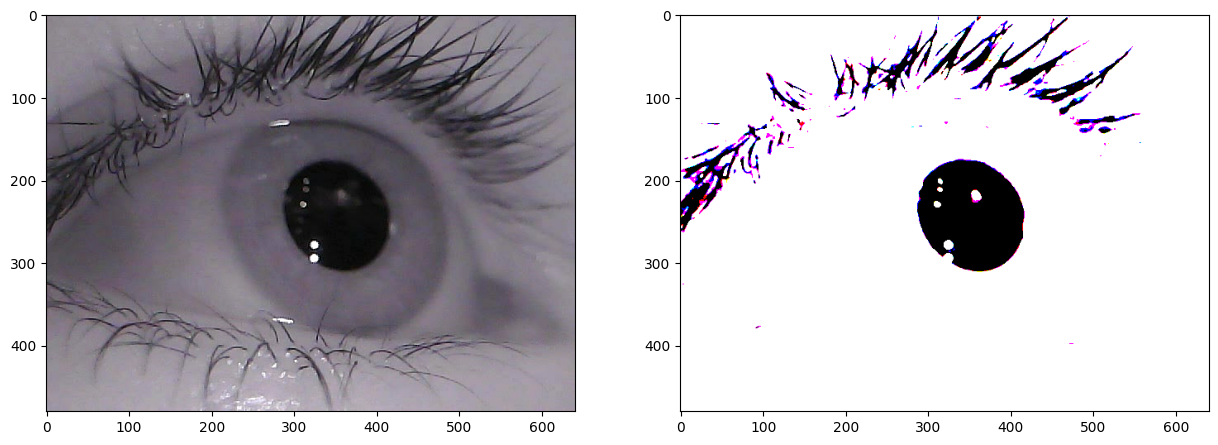

In [50]:
from skimage.io import imread
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage import img_as_float

img = imread('eye.png')

filtered_img = gaussian(img, sigma=1)
T = threshold_otsu(filtered_img)
print(T)
segmentation = filtered_img > 0.2
segmentation = img_as_float(segmentation)

fig, axes = plt.subplots(figsize=(15, 10), ncols=2)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(segmentation, cmap ="gray")

In [55]:
def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.02):
    """
    The Canny edge detector.

    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will
                         be considered the lo threshold.
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x
                         thresh_lo.

    Outputs:
        edge_img         A binary image, with pixels lying on edges marked with a 1,
                         and others with a 0.
    """

    # Smooth the image first.
    smoothed             = gaussian_smoothing(img)

    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)

    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)

    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)

    # Final edge connectivity
    edge_img             = connectivity(thresh_img)

    # Return the result
    return edge_img


edges = canny_edge_detector(segmentation)

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(edges, cmap='gray')

RuntimeError: filter weights array has incorrect shape.

### Bilateral Filtering


In [4]:
from scipy.signal import gaussian
from scipy.stats import norm

def generate_gaussian_kernel(sigma, neigh):
    """
    Gaussian kernel generator.

    Inputs:
        sigma:     Std of Gaussian
        neigh:     Size of window
    """

    kernel_1d = gaussian(M=neigh, std=sigma)
    kernel = np.outer(kernel_1d, kernel_1d)

    return kernel / np.sum(kernel)

In [7]:
def bilateral_filtering(img, sigma_s, sigma_r):
    """
    Bilateral Filtering.

    Inputs:
        img:           The input image
        sigma_s:       Std of the spatial Gaussian
        sigma_r:       Std of the range Gaussian

    Outputs:
        bilateral_img    A smoothed image
    """

    # Get image dimensions

    h, w = img.shape

    # Initialize output image with same dimensions as input image
    bilateral_img = np.zeros_like(img)

    # Compute size of window (neighborhood) to use based on sigma_s
    neigh = int(sigma_s * 6 + 1)  # ensure approx. 3 std

    # Compute padding size
    pad = (neigh - 1) // 2

    # Pad input image with zeros to avoid boundary issues
    img = np.pad(img, pad_width=pad)

    # Generate spatial Gaussian kernel
    kernel = generate_gaussian_kernel(sigma_s, neigh)

    # Iterate over each pixel in padded image
    for i in range(pad, h + pad):
        for j in range(pad, w + pad):
            # Extract window of neighboring pixels around center pixel
            window = img[i - pad:i + pad + 1, j - pad:j + pad + 1]
            # Get intensity value of center pixel
            center_pixel = img[i, j]
            # Compute range weight for each pixel based on intensity difference
            # between center pixel and neighboring pixel
            range_factor = np.exp(-((window - center_pixel) ** 2) / (2 * sigma_r ** 2))
            # Combine spatial and range weights to obtain final weight for each pixel
            weight = kernel * range_factor
            # Compute weighted sum of neighboring pixels
            bilateral_img[i - pad, j - pad] = np.sum(window * weight)
            # Compute normalization factor
            wp = np.sum(weight)
            # Normalize weighted sum by normalization factor
            bilateral_img[i - pad, j - pad] /= wp

    # Return the result
    return bilateral_img


<function matplotlib.pyplot.show(close=None, block=None)>

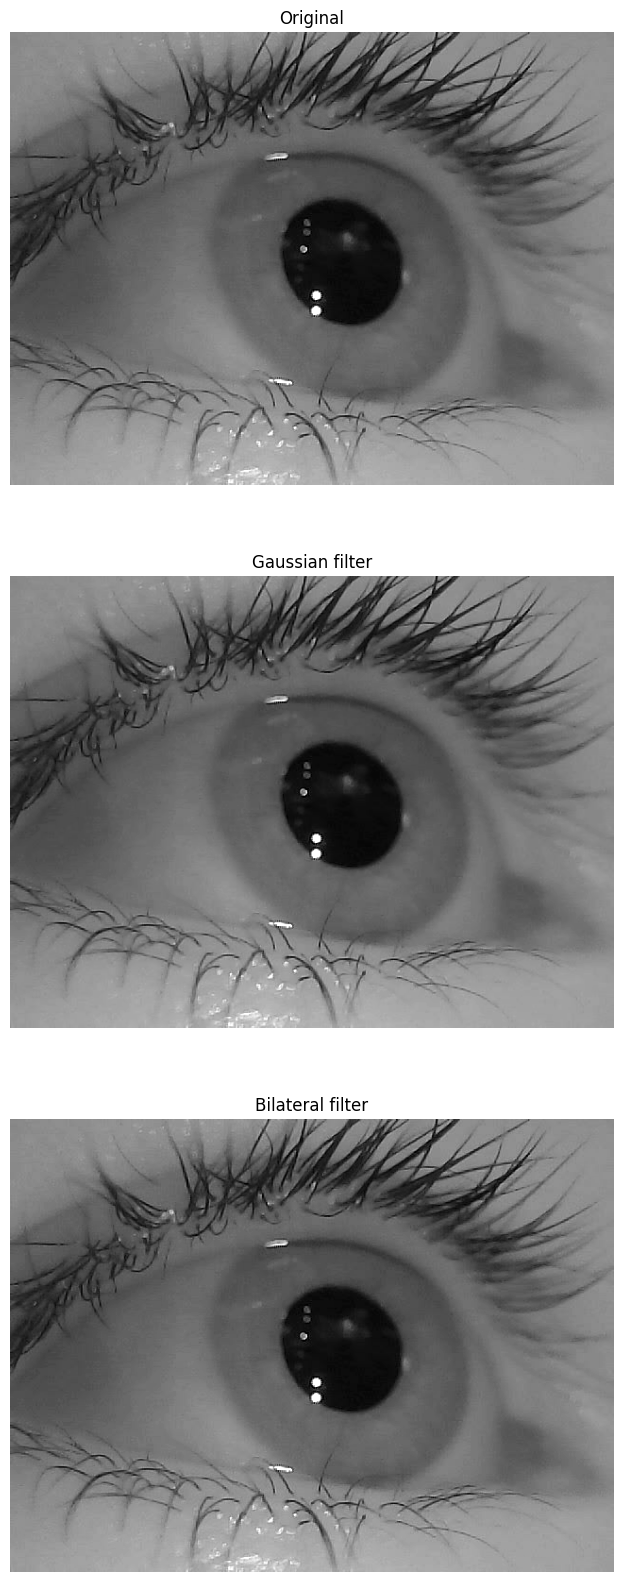

: 

In [90]:
import cv2
import numpy as np 

# Load the image
image = cv2.imread('eye.png')

img = ray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sigma_s = 0.3
sigma_r = 5

bf_img = bilateral_filtering(img, sigma_s, sigma_r)

g_img = gaussian_filter(img, sigma_s)

fig, axes = plt.subplots(figsize=(8, 20), nrows=3)

for i, (image, name) in enumerate(zip([img, g_img, bf_img],
                                 ['Original', 'Gaussian filter', 'Bilateral filter'])):

    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(name)

plt.show

Ne comprend pas pourquoi je dois changer autant le sigma pour qu'on ai un résultat. Si je garde le sigma de base j'ai une image toute noire

### SHIFT

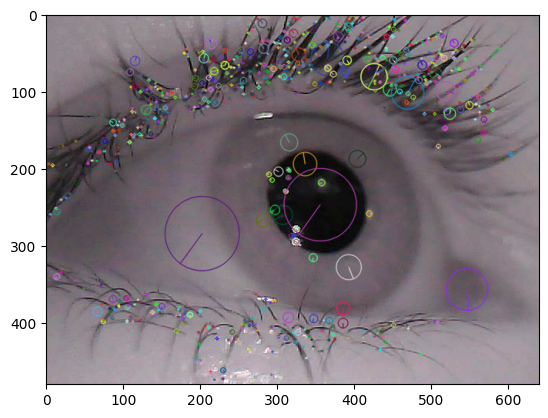

In [33]:
from cv2 import SIFT_create
import numpy as np

img = cv2.imread('eye.png')

sift = SIFT_create()

keypoints, descriptors = sift.detectAndCompute(img, None)

img_keypoints = cv2.drawKeypoints(img, keypoints, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_keypoints)


### Region growing

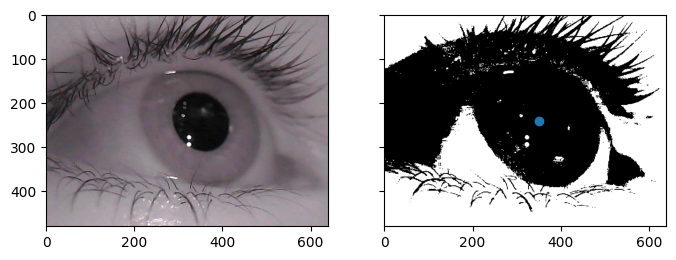

In [84]:
import skimage
from skimage import io, filters, feature, color
import matplotlib.pyplot as plt


# Load the image
image = cv2.imread('eye.png')
img  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

threshold = filters.threshold_otsu(img)
image_binary = img > threshold

seed = (350, 240)
region = skimage.segmentation.flood_fill(image_binary, seed, connectivity=4, new_value=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
ax[0].imshow(image)
ax[1].imshow(region, cmap='gray')
ax[1].scatter(seed[0], seed[1])
plt.show()


### K-means

In [75]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 4
m,n = img.shape

# Load the image
image = cv2.imread('eye.png')
img  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

X = img.flatten().reshape(k, 3)

kmeans = KMeans(n_clusters=k).fit(X)

# Get the cluster assignments for each pixel
clusters = kmeans.predict(X)

# Create an empty image with the same dimensions as the input image
segmented_image = np.zeros_like(img)

# Use a colormap to assign colors to the segments
cmap = plt.cm.get_cmap('viridis', k)
colors = cmap(clusters)

# Fill the segmented image with the appropriate colors
for i in range(m):
    for j in range(n):
        segmented_image[i, j] = colors[i * n + j]



ValueError: cannot reshape array of size 307200 into shape (4,3)

In [79]:
import numpy as np
import cv2 as cv

img = cv.imread('eye.png')
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
cv.imshow('res2',res2)
cv.waitKey(0)
cv.destroyAllWindows()